Text(0, 0.5, 'nominal rate, in %')

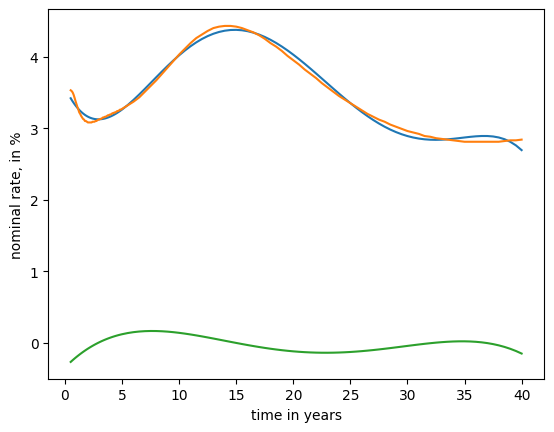

In [2]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("jan_curve.csv", delimiter=",", dtype=float)

x = data[:,0]
y = data[:,1]

spl = interpolate.UnivariateSpline(x,y,k=5)
plt.plot(x,spl(x))
plt.plot(x,y)
plt.plot(x,spl.derivative()(x))
plt.xlabel("time in years")
plt.ylabel("nominal rate, in %")

In [23]:
a = 0.1
sigma = 0.1

F = -spl.derivative()(x)
theta = -spl.derivative(n=2)(x) + a * F + sigma**2/a * (1-np.exp(-2 * a * x))

theta_spl = interpolate.UnivariateSpline(x, theta)
# plt.plot(x,theta)
# plt.plot(x,theta_spl(x))
# plt.xlabel("time in years")
# plt.ylabel("theta")

final_thetas = theta_spl(range(1,int(x[-1] + 1)))
print(len(final_thetas))
print( final_thetas)

40
[-0.09592369 -0.06244385 -0.03235271 -0.00548885  0.01830917  0.03920281
  0.0573535   0.07292267  0.08607178  0.09696226  0.10575556  0.11261311
  0.11769636  0.12116674  0.1231857   0.12391468  0.12351512  0.12214847
  0.11997615  0.11715962  0.11386031  0.11023967  0.10645913  0.10268015
  0.09906415  0.09577258  0.09296688  0.09080849  0.08945885  0.08907941
  0.08983161  0.09187688  0.09537666  0.10049241  0.10738555  0.11621753
  0.1271498   0.14034378  0.15596093  0.17416268]
